In [1]:
# Imports 
import pandas as pd
from datetime import datetime
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from Cleaning import GetCleanedData

#for LDA:
import gzip
import tarfile
import xml.etree.ElementTree as ET
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Data cleaning

### 1st dataset
After some data exploration we decided to clean the data. 
- Rows with missing Movie country, languages or genres were dropped
- Only the year of the movie release date was kept
- Only the first genre of a movie was kept

We saw that when we clean the rows that do not contain values of box office revenue the dataset is seriously reduced. Our idea was to keep a version of the dataset without taking care of the box office revenue when it is not the target of the analysis. We notice that the size difference between  df_date_revenue_clean and df_date_revenue_runtime_clean is negligeable, no need to treat them separately.

In [2]:
# Importing data
PATH = 'src'
header = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 
          'Movie languages', 'Movie country', 'Movie genres']
df = pd.read_csv(PATH + '/movie.metadata.tsv', sep='\t', names=header, skipinitialspace=True)


In [3]:
print("Data set initial size = ", df.size)
print("Number of NaN values for each columns:")
if df.isnull().values.any():
    print(df.isnull().sum())

Data set initial size =  735669
Number of NaN values for each columns:
Wikipedia movie ID              0
Freebase movie ID               0
Movie name                      0
Movie release date           6902
Movie box office revenue    73340
Movie runtime               20450
Movie languages                 0
Movie country                   0
Movie genres                    0
dtype: int64


In [4]:
df_date_clean, df_date_revenue_clean, df_date_revenue_runtime_clean = GetCleanedData(df)

print('Size of the data with the dates cleaned up : ', df_date_clean.size)
print('Size of the data with the dates and the box office revenues cleaned up : ', df_date_revenue_clean.size)
print('Size of the data with the dates, the box office revenues and the runtimes cleaned up : ', df_date_revenue_runtime_clean.size)

Size of the data with the dates cleaned up :  555498
Size of the data with the dates and the box office revenues cleaned up :  72198
Size of the data with the dates, the box office revenues and the runtimes cleaned up :  71829


In [5]:
# Storage of clean df in data folder

DATA_PATH = 'data'
os.makedirs(DATA_PATH, exist_ok=True)  # Creation of data folder if it does not exist

df_date_clean.to_csv(DATA_PATH + '/df_date_clean.csv', index=False)
df_date_revenue_clean.to_csv(DATA_PATH + '/df_date_revenue_clean.csv', index=False)
df_date_revenue_runtime_clean.to_csv(DATA_PATH + '/df_date_revenue_runtime_clean.csv', index=False)


In [6]:
df_date_revenue_runtime_clean.sample(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
47076,240376,/m/01jw83,Only When I Laugh,1981,25524778.0,120.0,[English Language],United States of America,Family Drama
39194,12624367,/m/02wykv1,Sweet Liberty,1986,14205021.0,106.0,[English Language],United States of America,Romantic comedy
24665,25913752,/m/0c1sgd3,Water for Elephants,2011,117094902.0,112.0,[English Language],United States of America,Animal Picture
53426,706863,/m/034fgm,Bordello of Blood,1996,5781045.0,87.0,[English Language],United States of America,Black comedy
77940,9139772,/m/027z3px,China Girl,1987,1262091.0,91.0,[English Language],United States of America,Romance Film


### 2nd dataset

No particular cleaning.

For now we did not use much of features in this dataframe, maybe in Milestone 3 we will use it and improve cleaning of this dataframe.

In [7]:
header2 = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date','Character Name', 'Actor DOB', 'Actor gender',
           'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age at movie release', 'Freebase character map']
df2 = pd.read_csv(PATH + '/character.metadata.tsv', sep='\t', index_col=False, names=header2, skipinitialspace=True, usecols=range(len(header2)))

In [8]:
df2.head(5)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character map
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


In [9]:
if df2.isnull().values.any():
    print(df2.isnull().sum())

Wikipedia movie ID                 0
Freebase movie ID                  0
Movie release date              9995
Character Name                257875
Actor DOB                     106145
Actor gender                   45609
Actor height                  295845
Actor ethnicity               344611
Actor name                      1228
Actor age at movie release    158113
Freebase character map             0
dtype: int64


### Merged dataset

We decided to merge both dataset into one dataframe. 

We previously cleaned both dataframe as needed so no further cleaning in this step, just merging and checking everything is as expected.

In [10]:
merged_df = pd.merge(df_date_clean, df2, on='Wikipedia movie ID', how='inner')

merged_df = merged_df.drop(columns=['Freebase movie ID_y', 'Movie release date_y'])

merged_df = merged_df.rename(columns={'Freebase movie ID_x': 'Freebase movie ID', 
                                      'Movie release date_x': 'Movie release date'})


In [11]:
if merged_df.isnull().values.any():
    print(merged_df.isnull().sum())

Wikipedia movie ID                 0
Freebase movie ID                  0
Movie name                         0
Movie release date                 0
Movie box office revenue      304688
Movie runtime                  34286
Movie languages                    0
Movie country                      0
Movie genres                       0
Character Name                220899
Actor DOB                      97401
Actor gender                   41620
Actor height                  264350
Actor ethnicity               309417
Actor name                      1100
Actor age at movie release    135626
Freebase character map             0
dtype: int64


In [12]:
# Check if there is duplicated row after the merge

count = 0
for i in range (len(merged_df)):
    if merged_df.iloc[i].duplicated().all():
        count+=1

print("Nb of duplicated row : ",count)

Nb of duplicated row :  0


In [13]:
# Check bound of date for the merged_df

min_date = merged_df['Movie release date'].min()
max_date = merged_df['Movie release date'].max()

print("Minimum date of merged_df : ", min_date)
print("Maximum fate of merged_df : ", max_date)

Minimum date of merged_df :  1888
Maximum fate of merged_df :  2015


In [14]:
merged_df.head(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character map
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


In [15]:
merged_df.to_csv(DATA_PATH + '/merged_df.csv', index=False)

# Data Analysis

### 1) Dataset Exploration

In [16]:
df_date_clean.describe()

,Wikipedia movie ID,Movie box office revenue,Movie runtime
count,6.172200e+04,8.022000e+03,5.088300e+04
mean,1.539422e+07,4.964957e+07,1.161860e+02
std,1.067139e+07,1.141114e+08,4.784624e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,5.698308e+06,2.248500e+06,8.300000e+01
50%,1.399151e+07,1.144700e+07,9.400000e+01
75%,2.405099e+07,4.304377e+07,1.070000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In the first part of this analysis, we focus on the first 18 countries which produce the more movies

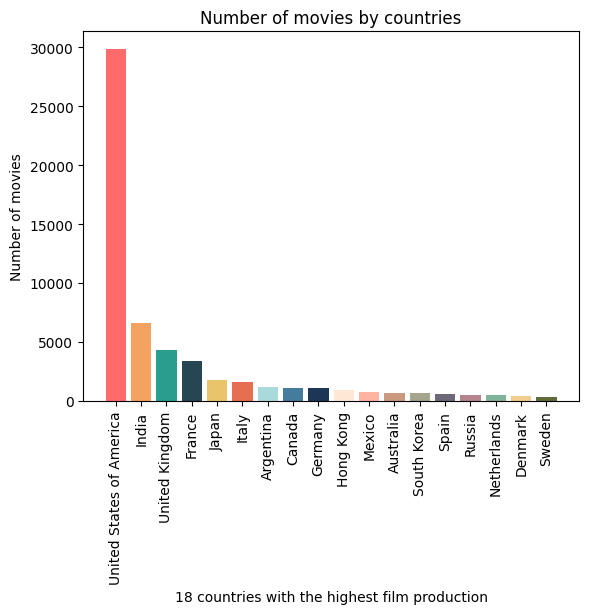

In [17]:
countries = df_date_clean.groupby(['Movie country']).count()['Wikipedia movie ID']

countries['Russia'] = countries['Russia'] + countries['Soviet Union']
countries['Germany'] = countries['Germany'] + countries['German Democratic Republic'] + countries['West Germany']
countries = countries.drop('Soviet Union')
countries = countries.nlargest(18)
countries_names = countries.index.to_list()

colors = [
    "#FF6B6B", "#F4A261", "#2A9D8F", "#264653", "#E9C46A", "#E76F51", "#A8DADC", "#457B9D", "#1D3557", "#FFE8D6", 
    "#FFB4A2",  
    "#CB997E",  
    "#A5A58D",  
    "#6D6875",  
    "#B5838D",  
    "#81B29A",  
    "#F2CC8F",  
    "#606C38" 
]


plt.bar(countries_names,countries,width=0.8, color = colors)
plt.xticks(rotation=90)
plt.xlabel('18 countries with the highest film production')
plt.ylabel('Number of movies')
plt.title('Number of movies by countries')
plt.show()

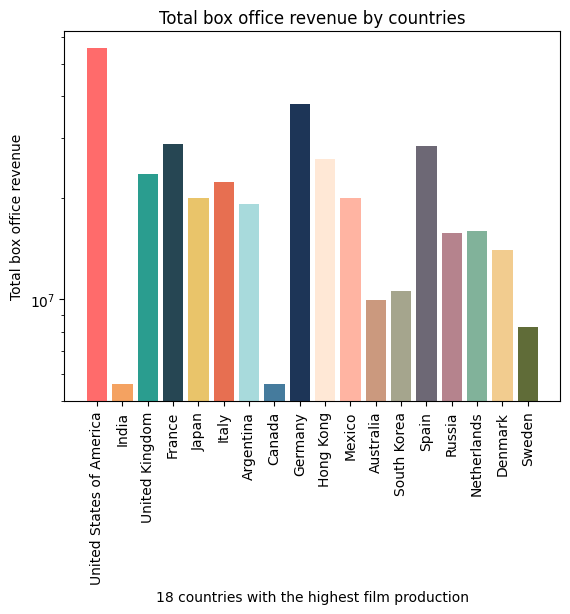

In [18]:
countries_revenues = df_date_revenue_clean.groupby(['Movie country'])['Movie box office revenue'].mean()
countries_revenues['Germany'] = (countries_revenues['Germany'] + countries_revenues['West Germany'])/2
countries_revenues = countries_revenues.drop('West Germany')
countries_revenues = countries_revenues[countries_names]

plt.bar(countries_names, countries_revenues, color = colors)
plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('18 countries with the highest film production')
plt.ylabel('Total box office revenue')
plt.title('Total box office revenue by countries')
plt.show()

In this section, we will focus on the 6 diverse film producers (USA, India, UK, Japan, Argentina and Iran) and analyse their movie production over the years, starting from 1890 to 2016.

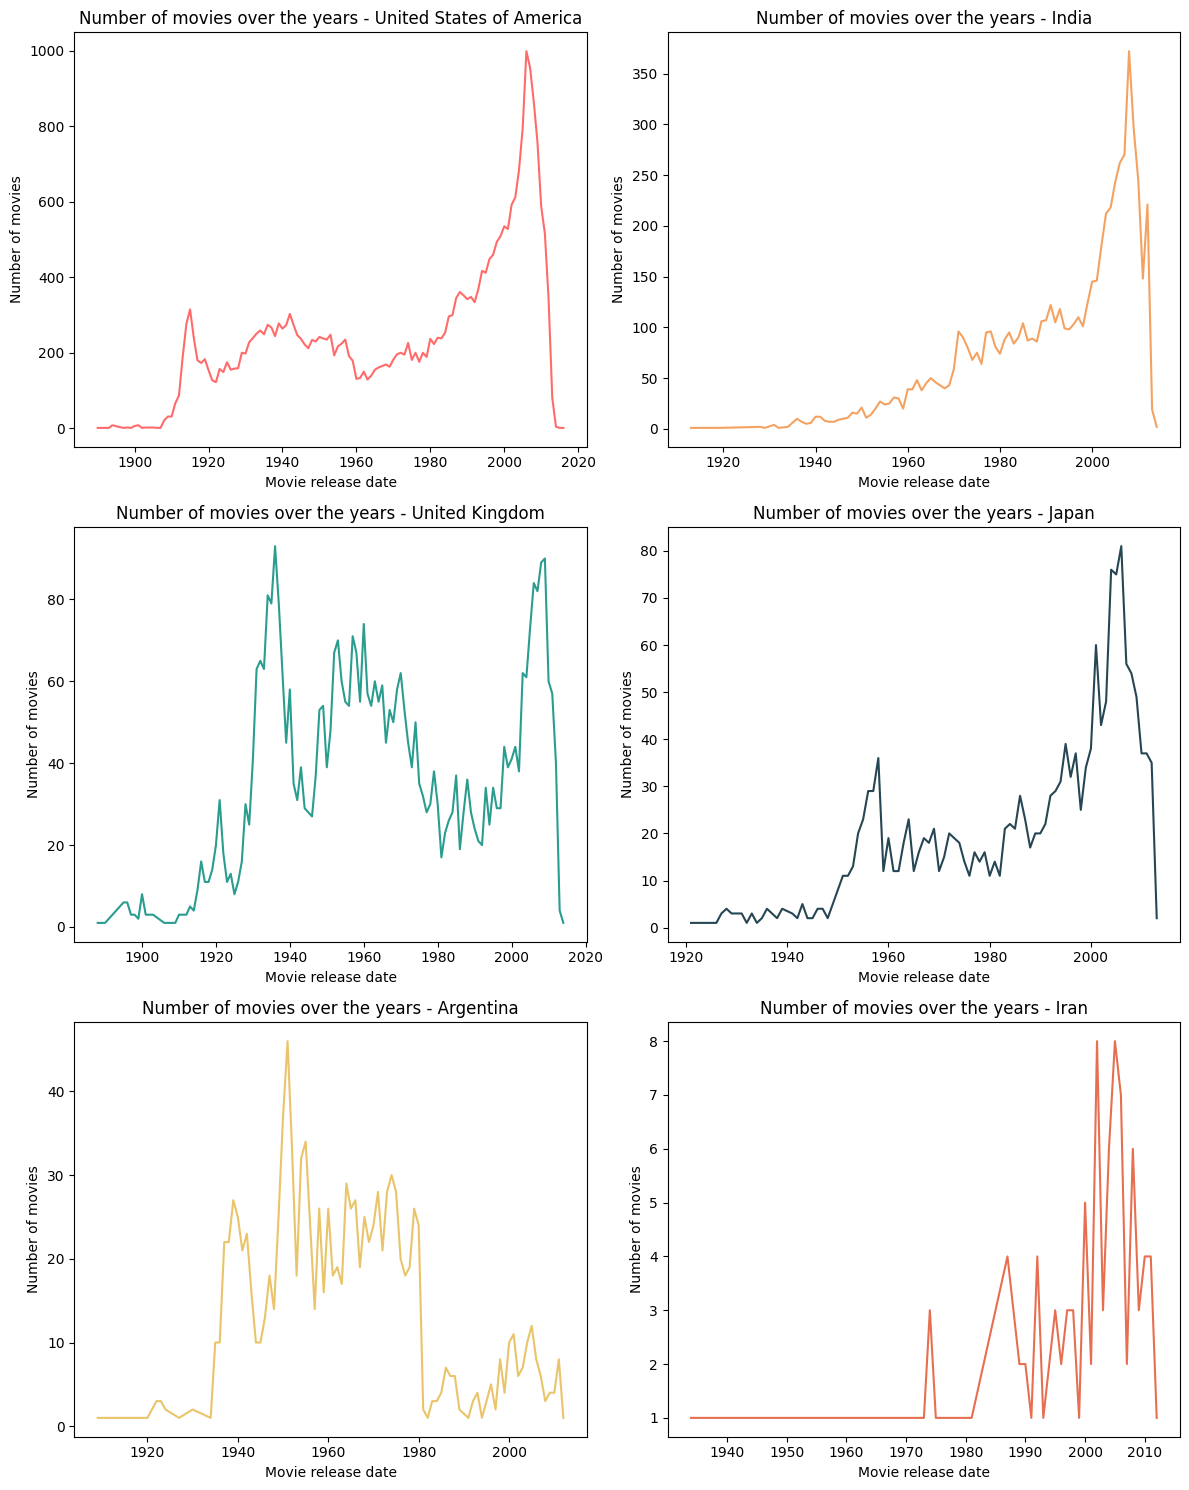

In [19]:
focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']
color_dict = dict(zip(focus_countries, colors))

df_focus = df_date_clean[df_date_clean['Movie country'].isin(focus_countries)]

nb_per_year = df_focus.groupby(['Movie country', 'Movie release date']).count()['Wikipedia movie ID']
nb_per_year = nb_per_year.reset_index()
nb_per_year = nb_per_year.rename(columns={'Wikipedia movie ID': 'Movie count'})

nb_per_year['Movie release date'] = pd.to_datetime(nb_per_year['Movie release date'], errors='coerce')

num_columns = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
axes = axes.flatten()

'''
for idx, country in enumerate(focus_countries):
    country_data = nb_per_year[nb_per_year['Movie country'] == country]
    
    axes[idx].plot(country_data['Movie release date'], country_data['Movie count'], linestyle='-', color=colors[idx])
    axes[idx].set_title(f"Number of movies over the years - {country}")
    axes[idx].set_xlabel("Movie release date")
    axes[idx].set_ylabel("Number of movies")

plt.tight_layout()
plt.show()
'''
for idx, country in enumerate(focus_countries):
    country_data = nb_per_year[nb_per_year['Movie country'] == country]
    axes[idx].plot(country_data['Movie release date'], country_data['Movie count'], linestyle='-', color=color_dict[country])
    axes[idx].set_title(f"Number of movies over the years - {country}")
    axes[idx].set_xlabel("Movie release date")
    axes[idx].set_ylabel("Number of movies")

plt.tight_layout()
plt.show()

The global trend that we see on the 6 graphs is an increase of the movie production between 1890 and 2007. We can interprate those result and estimate that the advancement of new technologies worldwide are the major cause of this increase.

We can observe a drop in the american movie production around 1915 which coincides with World War I. It did not really affected the UK because their movie production was very low at that time. India, Argentina, Iran and Japan was not involved in World War I. Concerning World War II the observation is a bit different. We notice a huge decrease of number of movie for the UK and Argentina around 1939-1945 and a less important one for the USA. UK and USA were directly involved in the World War II while Argentina had the influence of Germany and Italy. Moreover, the number of movies produced per yer before 1940 for Japan is very low but we can observe that this number increases a lot after World War II. 

Around 2007, we discern a fall of prodcution for the 6 countries. This date corresponds to the appearance of Netflix, a platform that offers a streaming service of movies, series. People can access to huge number of movies very easily without having to go to cinema theatres. 2008 economic crisis could also have an impact on this production of movies.

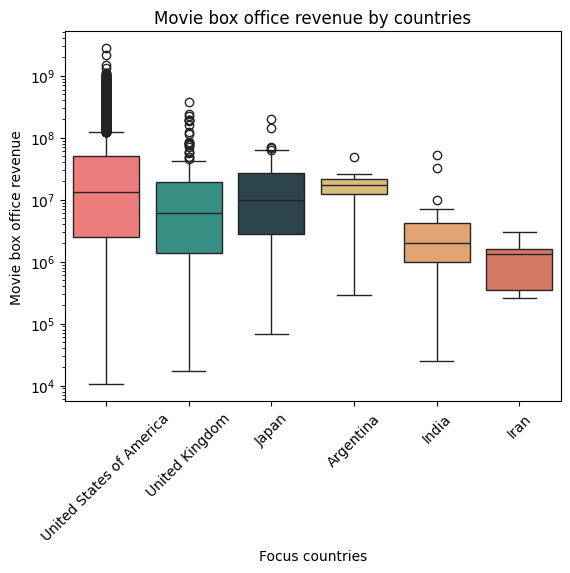

In [20]:
df_revenue_focus = df_date_revenue_clean[df_date_revenue_clean['Movie country'].isin(focus_countries)]

countries_revenues = df_revenue_focus.groupby(['Movie country'])['Movie box office revenue']

'''
color_dict = dict(zip(focus_countries, colors))
sns.boxplot(x='Movie country', y='Movie box office revenue', data=df_revenue_focus, palette=color_dict)
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel('Focus countries')
plt.ylabel('Movie box office revenue')
plt.title('Movie box office revenue by countries')
plt.show()
'''

sns.boxplot(x='Movie country', y='Movie box office revenue', hue='Movie country', data=df_revenue_focus, palette=color_dict, dodge=False, legend=False)
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel('Focus countries')
plt.ylabel('Movie box office revenue')
plt.title('Movie box office revenue by countries')
plt.show()

India is the second country with the highest number of films produced however the boxplot shows that the movie box office revenue per film is lower than UK, Japan or Argentina even if these countries produce less films. 

USA is still the first country and there are a lot of outliers with a high movie box office revenue. 

Argentina is the 7 country with the highest nb of films produced, after USA, India, UK and Japan. However, we can observe that in mean, it has a highest movie box office revenue per film than these countries. It also has a lower difference between first and third quartile. However it has just one outliers with a abnormaly high movie box office revenue. 

Iran is the country with the lowest number of film produced and also, in average, the lowest movie box office revenue. Nonetheless, it has the lowest gap between whiskers meaning that the distribution of the box office revenue per film is consistent.

# Correlation

In this part, we explore the correlation between GDP and movie industry.

<Axes: xlabel='Movie Count Range', ylabel='Revenue Range'>

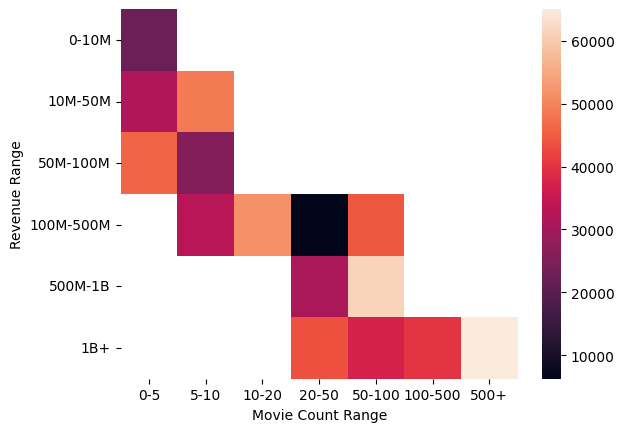

In [21]:
# HEATMAP 

# Import GDP df
df_gdp = pd.read_csv(PATH + '/GDP.csv', sep=';',)
df_gdp = df_gdp.rename(columns={"Country": "Movie country"})

# Preparation of data for the heatmap
nb_per_year = df_date_revenue_clean.groupby(['Movie country', 'Movie release date']).count()['Wikipedia movie ID']
nb_per_year = nb_per_year.reset_index()
nb_per_year = nb_per_year.rename(columns={'Wikipedia movie ID': 'Movie count'})
nb_per_year['Movie release date'] = pd.to_datetime(nb_per_year['Movie release date'], errors='coerce')

total_films_per_country = nb_per_year.groupby('Movie country')['Movie count'].sum().reset_index()
total_films_per_country.columns = ['Movie country', 'Total Movie Count']
df_correlation = pd.merge(df_gdp,total_films_per_country, on='Movie country')

total_revenue_per_country = df_date_revenue_clean.groupby('Movie country')['Movie box office revenue'].sum().reset_index()
total_revenue_per_country.columns = ['Movie country', 'Total Box office revenue']

df_correlation = pd.merge(df_correlation, total_revenue_per_country, on='Movie country')

df_correlation['Revenue Range'] = pd.cut(df_correlation['Total Box office revenue'], 
                                         bins=[0, 1e7, 5e7, 1e8, 5e8, 1e9, df_correlation['Total Box office revenue'].max()],
                                         labels=['0-10M', '10M-50M', '50M-100M', '100M-500M', '500M-1B', '1B+'])
df_correlation['Movie Count Range'] = pd.cut(df_correlation['Total Movie Count'], 
                                             bins=[0, 5, 10, 20, 50, 100, 500, df_correlation['Total Movie Count'].max()],
                                             labels=['0-5', '5-10', '10-20', '20-50', '50-100', '100-500', '500+'])

df3 = pd.crosstab(
    df_correlation['Revenue Range'],
    df_correlation['Movie Count Range'],
    values=df_correlation['GDP per capita (constant US$)'],
    margins=False,
    aggfunc='mean'
)

sns.heatmap(df3, annot=False)

We can observe that lighter colors, which represent higher GDP, are primarily located towards the bottom right of the heatmap. This indicates that countries with high GDP tend to produce a large number of movies with high box office revenue. In contrast, darker colors, representing lower GDP, are predominantly found towards the top left of the heatmap, suggesting that countries with low GDP produce fewer movies and generate lower box office revenue.

However, we also notice some darker colors around the middle of the heatmap. This suggests that some countries with low GDP are still able to produce a moderate number of movies, and these films tend to achieve relatively good box office performance.

In [22]:
# Cleaning for Pearson correlation 

# Merge with GDP df
df_date_revenue_clean = df_date_revenue_clean.merge(df_gdp[['Movie country', 'GDP per capita (constant US$)']], 
                            on='Movie country', 
                            how='left')

df_date_revenue_clean = df_date_revenue_clean.dropna(subset=['GDP per capita (constant US$)'])

### Pearson correlation

In [23]:
# Between movie box office revenue and GDP

stats.pearsonr(df_date_revenue_clean['Movie box office revenue'],df_date_revenue_clean['GDP per capita (constant US$)'])

PearsonRResult(statistic=0.0994870878001062, pvalue=4.0000430002900215e-19)

There is a small but significant correlation between Movie box office revenue and GDP

In [24]:
# Between number of film produced and GDP

df_countries = countries.to_frame()
df_countries = df_countries.merge(df_gdp[['Movie country', 'GDP per capita (constant US$)']], 
                            on='Movie country', 
                            how='left')
df_countries = df_countries.rename(columns={"Wikipedia movie ID": "Nb of film produced"})

stats.pearsonr(df_countries['Nb of film produced'],df_countries['GDP per capita (constant US$)'])


PearsonRResult(statistic=0.23908261997257524, pvalue=0.32424012222681325)

The correlation between the number of film produced and the GDP is not significant. 

# Movie genres

In this part we will explore the repartition of movie genres in movie industry.

In [25]:
# We focus on 5 main genres

focus_genres = ['Drama','Thriller','Comedy','Romance Film','Crime Fiction']

In [26]:
dfs_countries = []
for country in focus_countries :
    df = df_date_clean[df_date_clean['Movie country'] == country]
    dfs_countries.append(df)

countries_grouped_genre = []

for df in dfs_countries :
    countries_grouped_genre.append(df.groupby(['Movie genres']).count()['Wikipedia movie ID'])

In [27]:
genres_data_by_country = []
for country_genres_nb in countries_grouped_genre :

    country_genres_nb['Romance Film'] = country_genres_nb['Romance Film'] + country_genres_nb.get('Romantic comedy', 0) + country_genres_nb.get('Romantic drama', 0)
    country_genres_nb['Action'] = country_genres_nb['Action'] + country_genres_nb.get('Action/Adventure', 0)
    country_genres_nb['Comedy'] = country_genres_nb['Comedy'] + country_genres_nb.get('Comedy film', 0)

    country_genres_nb = country_genres_nb[focus_genres]

    genres_data_by_country.append(country_genres_nb)

In [28]:
print(genres_data_by_country[0])

Movie genres
Drama            2289
Thriller         3594
Comedy            948
Romance Film     2780
Crime Fiction    2192
Name: Wikipedia movie ID, dtype: int64


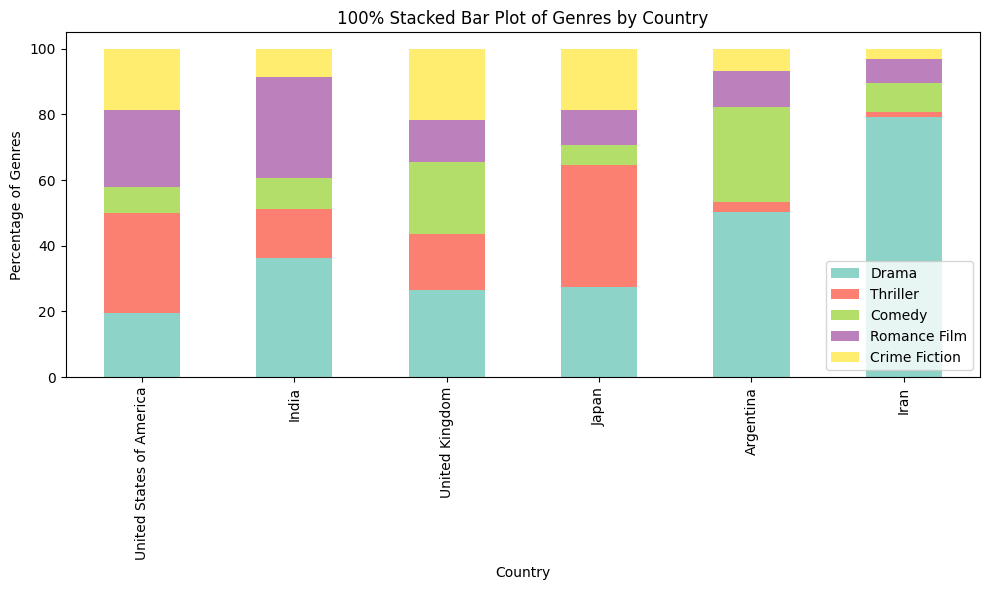

In [29]:
array_tot = []
for i in range(len(focus_countries)):
    v = [focus_countries[i]] + genres_data_by_country[i].values.tolist()
    array_tot.append(v)

df_tot = pd.DataFrame(array_tot, columns=['Countries'] + focus_genres)


df_normalized = df_tot.set_index('Countries')
df_normalized = df_normalized.div(df_normalized.sum(axis=1), axis=0) * 100


ax = df_normalized.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
ax.set_xlabel('Country')
ax.set_ylabel('Percentage of Genres')
ax.set_title('100% Stacked Bar Plot of Genres by Country')

plt.tight_layout()
plt.show()

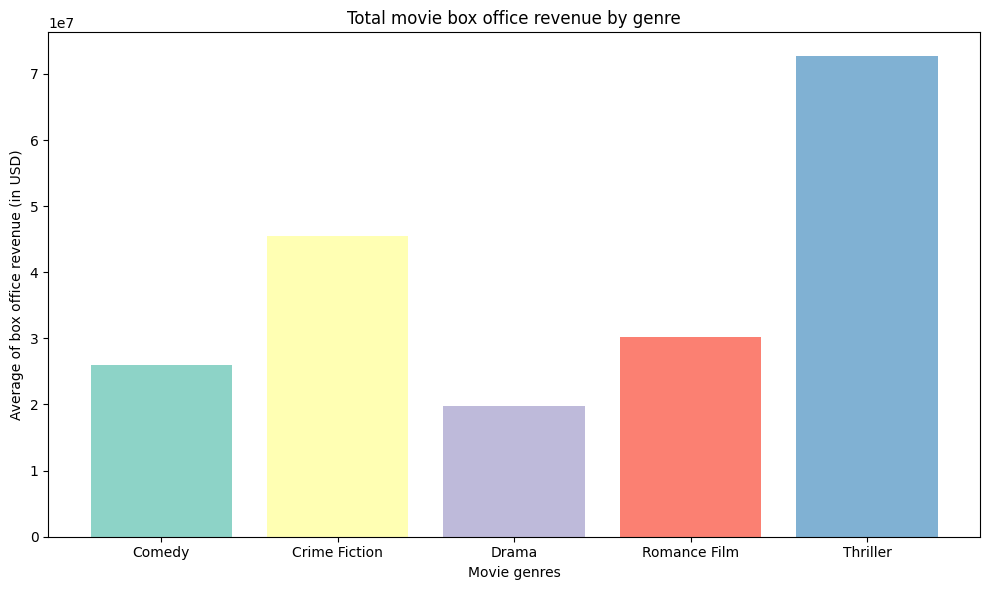

In [30]:
by_genres_stats = df_date_revenue_clean.groupby('Movie genres')['Movie box office revenue'].agg('mean').reset_index()
by_genres_stats.columns = ['Movie genres', 'Average revenue']

filtered_genres_stats = by_genres_stats[by_genres_stats['Movie genres'].isin(focus_genres)]

# Keep the same color as above 
colormap = matplotlib.colormaps['Set3']
colors = [colormap(i) for i in range(len(focus_genres))]

plt.figure(figsize=(10, 6))
plt.bar(filtered_genres_stats['Movie genres'], filtered_genres_stats['Average revenue'], color=colors)
plt.xlabel('Movie genres')
plt.ylabel('Average of box office revenue (in USD)')
plt.title('Total movie box office revenue by genre')
plt.tight_layout()
plt.show()

The genre with the highest average of box office revenue is Thriller. Japan and USA are producing a lot of Thriller movies. However Drama is the genre with the lowest average of box office revenue. Iran and Argentina are producing mainly Drama movies. India produces almost the same amount of Drama and Romance movies but both are not genres with a high average of box office revenue. UK is the only country with a quite proportional repartition between genres with almost the same amount of movies produced for every genre. 

Note : Thriller is the genre with the highest average of box office revenue. But is it because USA produces a lot of Thriller movies ? We know that USA are the country with the highest average of box office revenue so maybe Thriller is the genre with the highest average of box office revenue because it is a genre that USA produces a lot. 

# Actor gender

In this part we analyse the repartition of the gender in movie industry in the 6 countries we are focusing on.

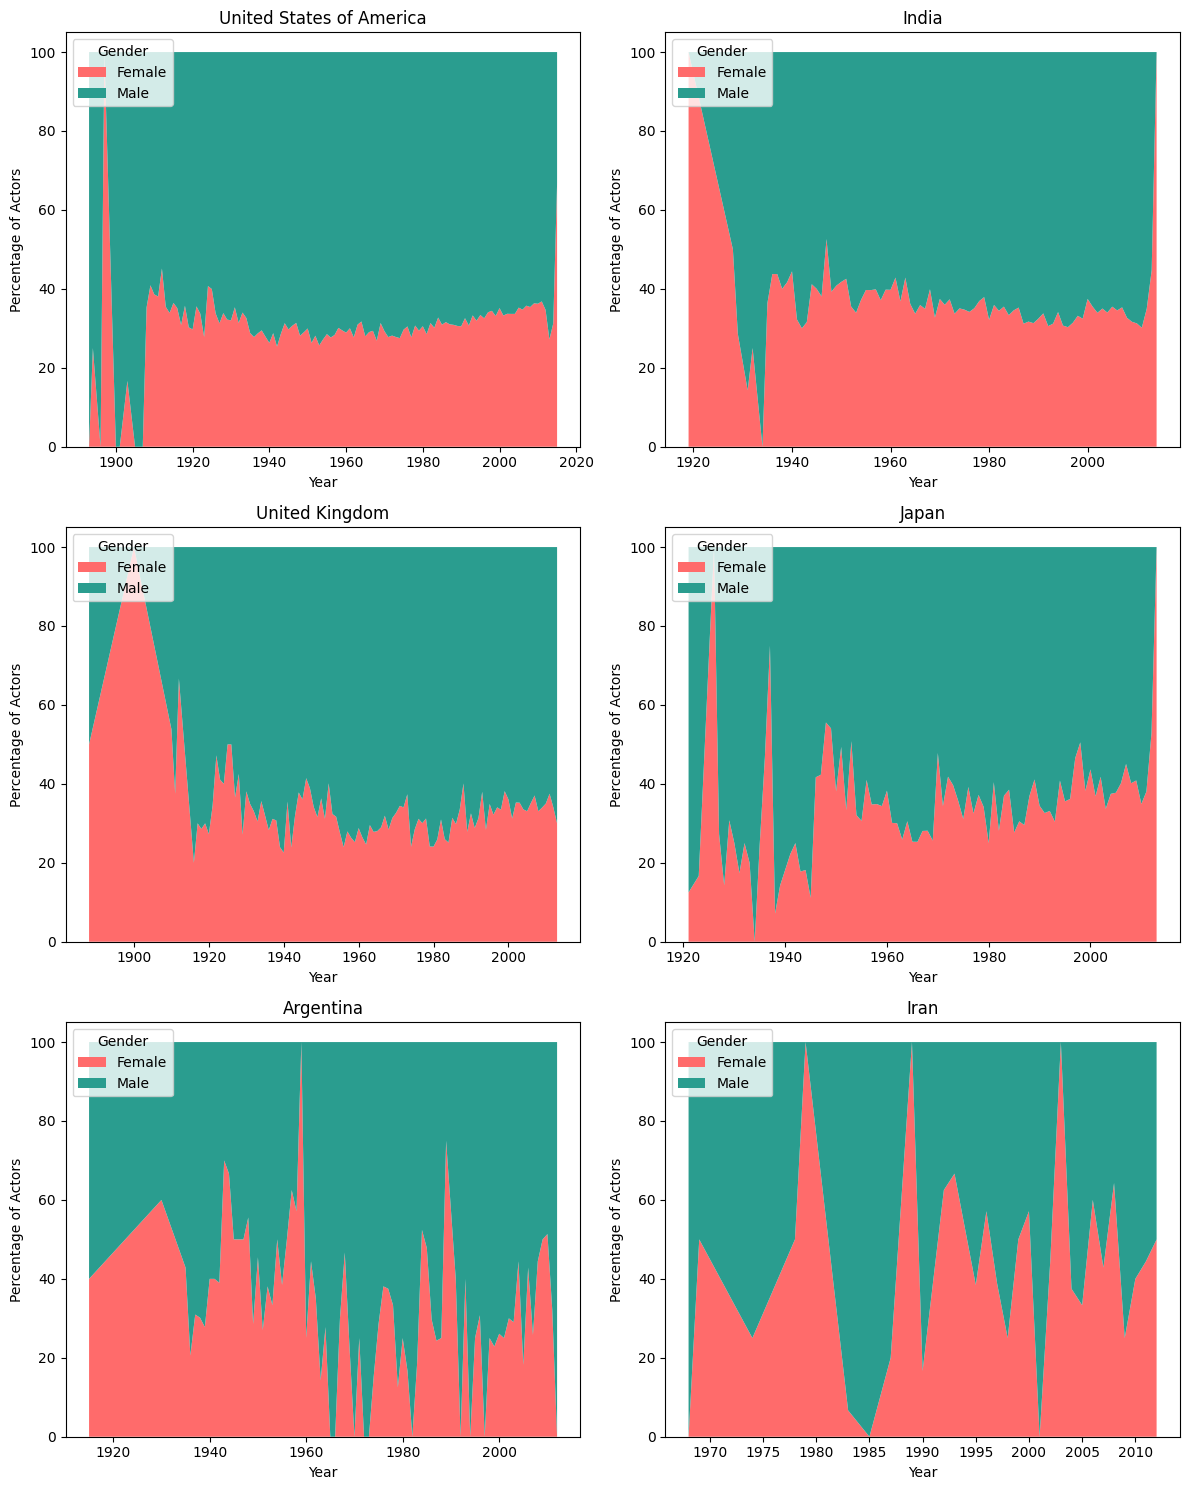

In [31]:
merged_df_focus = merged_df[merged_df['Movie country'].isin(focus_countries)]
actor_counts = merged_df_focus.groupby(['Movie release date', 'Movie country', 'Actor gender']).size().reset_index(name='Count')
total_counts = actor_counts.groupby(['Movie release date', 'Movie country'])['Count'].transform('sum')
actor_counts['Percentage'] = (actor_counts['Count'] / total_counts) * 100

actor_counts['Movie release date'] = pd.to_datetime(actor_counts['Movie release date'], errors='coerce')


num_rows, num_columns = 3, 2
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
axes = axes.flatten()  

# Plot for each country on a separate subplot
for i, country in enumerate(focus_countries):
    ax = axes[i]
    country_data = actor_counts[actor_counts['Movie country'] == country]  # Filter data for the country
    
    # Pivot data for stackplot: years as x, male/female percentages as y
    pivot_data = country_data.pivot(index='Movie release date', columns='Actor gender', values='Percentage').fillna(0)
    years = pivot_data.index
    male_percentage = pivot_data.get('M', 0)
    female_percentage = pivot_data.get('F', 0)
    
    # Plot the stackplot for male and female percentages
    ax.stackplot(years, female_percentage, male_percentage, labels=['Female', 'Male'], colors=["#FF6B6B", "#2A9D8F"])
    
    # Customize each subplot
    ax.set_title(f'{country}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of Actors')
    ax.legend(loc='upper left', title='Gender')

plt.tight_layout()
plt.show()


## Latent Dirichlet Allocation (LDA) for thematic analysis
We are now working with the Stanford CoreNLP-Processed Summaries (628 MB): Plot summaries from the metadata dataset, processed for linguistic analysis (tagging, parsing, named entity recognition, coreference). 
This is a nice way to select only the words that are meaningfull to define a theme with the LDA:
- The common nouns
- The verbs
- The adjectives

Among those words, we did one more selection by choosing manually a list of weak_verbs that we judge not meaningfull to define a theme and therefore, will be ignored in the LDA.
 

In [32]:
weak_verbs = {
    "accept", "achieve", "act", "add", "admit", "affect", "afford", "agree", "aim", "allow", "appear", "apply", "argue",
    "arrange", "arrive", "ask", "assume", "avoid", "be", "become", "begin", "believe", "belong", "bring", "build", "buy", "call",
    "carry", "cause", "change", "choose", "claim", "close", "collect", "come", "commit", "compare", "complete",
    "consider", "consist", "continue", "contribute", "control", "cope", "create", "cut", "deal", "decide", "decline",
    "deliver", "demand", "depend", "describe", "design", "destroy", "determine", "develop", "die", "differ", "discover",
    "discuss", "display", "do", "dominate", "draw", "dress", "drink", "drive", "eat", "encourage", "end", "enjoy",
    "enter", "establish", "examine", "exist", "expect", "experience", "explain", "express", "fail", "fall", "feel",
    "fight", "find", "follow", "form", "function", "gain", "get", "give", "go", "grow", "guess", "handle", "happen",
    "have", "hear", "help", "hide", "hold", "hope", "identify", "imagine", "implement", "improve", "include", "increase",
    "influence", "inform", "initiate", "insist", "intend", "introduce", "involve", "join", "keep", "kill", "know",
    "laugh", "lead", "learn", "leave", "let", "lie", "like", "listen", "live", "look", "lose", "love", "maintain",
    "make" , "manage", "matter", "mean", "measure", "meet", "mention", "mind", "miss", "move", "need", "note", "notice",
    "observe", "obtain", "occur", "offer", "open", "operate", "organize", "own", "participate", "pass", "pay", "perform",
    "plan", "play", "possess", "prefer", "prepare", "present", "prevent", "proceed", "produce", "provide", "pull", "put",
    "raise", "reach", "read", "realize", "receive", "recognize", "record", "reduce", "refer", "reflect", "refuse",
    "regard", "relate", "remain", "remember", "remove", "report", "represent", "require", "resolve", "respond",
    "result", "reveal", "rise", "run", "save", "say", "see", "seem", "select", "sell", "send", "serve", "set", "share",
    "show", "sit", "sleep", "solve", "speak", "spend", "stand", "start", "state", "stay", "stop", "study", "suggest",
    "supply", "support", "suppose", "survive", "take", "talk", "teach", "tell", "tend", "test", "think", "touch",
    "train", "try", "turn", "understand", "use", "vary", "view", "visit", "wait", "walk", "want", "watch", "wear",
    "win", "wish", "work", "write"
}


# function that extracts the meaningful words in each XML file
def parse_corenlp_file(file):
    with gzip.open(file, 'rt', encoding='utf-8') as f:
        tree = ET.parse(f)
        root = tree.getroot()
        filtered_words = []
        for token in root.iter('token'):
            lemma = token.find('lemma').text
            pos = token.find('POS').text
            if pos in {'NN', 'NNS'} or pos.startswith('VB') or pos.startswith('JJ'):
                if lemma.lower() not in weak_verbs:
                    filtered_words.append(lemma)
        return ' '.join(filtered_words)

We are now reading the entire corenlp_plot_summaries.tar zip file, which should be located in the parent directory of the GitHub repository on your local computer (as outlined in the README.md):

In [33]:
tar_path = '../corenlp_plot_summaries.tar'

documents = []
ids = []

with tarfile.open(tar_path, 'r') as tar:
    for member in tar.getmembers():
        if member.name.endswith('.xml.gz'):
            with tar.extractfile(member) as xml_gz_file:
                film_id = member.name.split('/')[-1].replace('.xml.gz', '')
                ids.append(film_id)
                document = parse_corenlp_file(xml_gz_file)
                documents.append(document)

In [34]:
# Vectorization for LDA
vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(documents)

# LDA
lda = LatentDirichletAllocation(n_components=4,random_state=42) # random seed for reproducibility
lda.fit(doc_term_matrix)
doc_topic_dist = lda.transform(doc_term_matrix)

Let’s identify the top 3 themes for each movie along with their respective proportions, and then merge this data with the existing movie information from the previously cleaned dataset:

In [35]:
top_themes_per_document = []
for i, doc in enumerate(doc_topic_dist):
    top_indices = doc.argsort()[-3:][::-1] # Indices of the top 3 values in the array doc, sorted in descending order. 
    top_proportions = doc[top_indices]

    top_themes_per_document.append({
        "Wikipedia movie ID": ids[i],
        "Thème 1": top_indices[0],
        "Prop Thème 1": top_proportions[0],
        "Thème 2": top_indices[1],
        "Prop Thème 2": top_proportions[1],
        "Thème 3": top_indices[2],
        "Prop Thème 3": top_proportions[2]
    })

df_top_themes = pd.DataFrame(top_themes_per_document)


df_date_clean['Wikipedia movie ID'] = df_date_clean['Wikipedia movie ID'].astype(str)
df_top_themes['Wikipedia movie ID'] = df_top_themes['Wikipedia movie ID'].astype(str)
merged_df = pd.merge(df_date_clean, df_top_themes, on='Wikipedia movie ID', how='inner')
merged_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,Thème 1,Prop Thème 1,Thème 2,Prop Thème 2,Thème 3,Prop Thème 3
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,3,0.554963,1,0.440645,0,0.002221
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],United Kingdom,Thriller,1,0.635593,0,0.186048,3,0.176834
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],Germany,Drama,0,0.739511,1,0.197227,2,0.061117
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],South Africa,Family Film,2,0.563673,1,0.308832,3,0.121564
4,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[English Language],United States of America,Romantic comedy,0,0.986124,2,0.004697,1,0.004666


To understand the themes better, we display the top 10 words that best represent each theme and also show the film with the highest proportion for that theme:

In [36]:
top_terms = []
terms = vectorizer.get_feature_names_out()
for index, topic in enumerate(lda.components_):
    top_terms.append([terms[i] for i in topic.argsort()[-10:]])

max_prop_movies = merged_df.loc[merged_df.groupby('Thème 1')['Prop Thème 1'].idxmax()]
max_prop_movies.head()


for index, row in max_prop_movies.iterrows():
    theme_id = row['Thème 1']
    print(f"Topic {theme_id} with top terms: {top_terms[theme_id]}")
    print(f"Top film for Topic {theme_id}: ID = {row['Wikipedia movie ID']}, Title = {row['Movie name']}\n")

Topic 0 with top terms: ['woman', 'time', 'marry', 'year', 'mother', 'friend', 'family', 'father', 'life', 'film']
Top film for Topic 0: ID = 4588808, Title = Thavamai Thavamirundu

Topic 1 with top terms: ['body', 'car', 'shoot', 'return', 'escape', 'death', 'house', 'murder', 'police', 'man']
Top film for Topic 1: ID = 1328234, Title = Cradle of Fear

Topic 2 with top terms: ['boy', 'family', 'money', 'time', 'home', 'day', 'house', 'other', 'friend', 'father']
Top film for Topic 2: ID = 3926180, Title = Franklin and the Green Knight

Topic 3 with top terms: ['soldier', 'attempt', 'group', 'order', 'force', 'man', 'other', 'ship', 'escape', 'attack']
Top film for Topic 3: ID = 32260, Title = U-571



Finally, we analyze the overall distribution of movie themes by country:

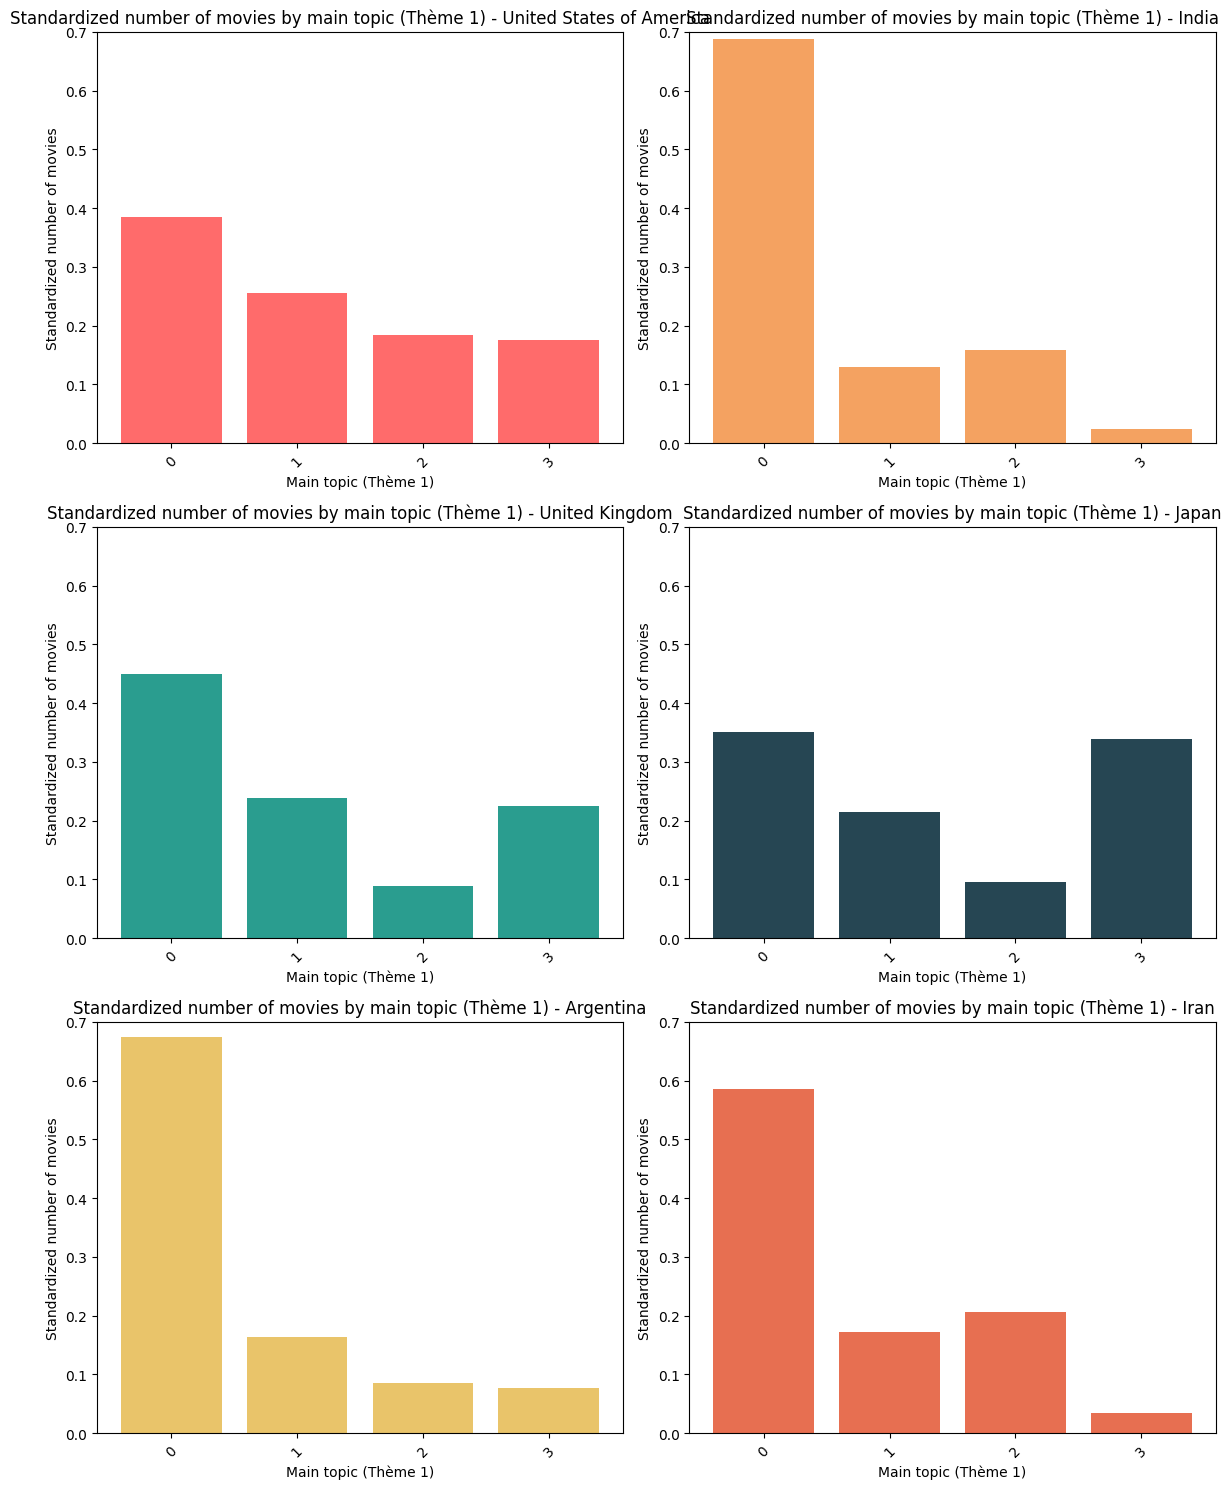

In [37]:
focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']

num_columns = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
axes = axes.flatten()

for idx, country in enumerate(focus_countries):
    # Filter movies by country
    movies = merged_df[merged_df['Movie country'] == country]
    
    # Count the main themes (Thème 1) and standardize the counts
    theme_counts = movies['Thème 1'].value_counts()
    theme_counts_stand = theme_counts / theme_counts.sum()
    
    # Plot as a bar chart
    axes[idx].bar(theme_counts_stand.index, theme_counts_stand.values,color=color_dict[country])
    axes[idx].set_title(f"Standardized number of movies by main topic (Thème 1) - {country}")
    axes[idx].set_xlabel("Main topic (Thème 1)")
    axes[idx].set_ylabel("Standardized number of movies")
    axes[idx].set_xticks(theme_counts_stand.index)  # Ensure theme indices show up correctly on x-axis
    axes[idx].set_xticklabels(theme_counts_stand.index, rotation=45)

for ax in axes:
    ax.set_ylim(0, 0.7)

plt.tight_layout()
plt.show()

Thematic analysis shows a strong preference for family and relationship narratives (Topic 0) across all countries, especially in India and Argentina. The U.S., U.K., and Japan display more diversity, including crime/action themes (Topic 1) and, in Japan’s case, military elements (Topic 3).

This thematic analysis is insightful for understanding overall trends, but we also want to perform a similar comparison focused on specific movie genres. It’s essential to distinguish between a film's genre and its themes, as a single genre can encompass a wide range of themes. By narrowing our analysis to one genre at a time, we aim to explore whether notable thematic differences exist across countries. For instance, within the drama genre, Japanese films might be more likely to explore military themes, whereas American dramas might lean towards themes that combine romance and tragedy. This genre-focused approach will help reveal how cultural contexts shape thematic choices within the same genre.

# Logistic Regression
Note : pour l'instant j'ai laissé pour pas perdre du travail mais ca run pendant une vie entière, je sais pourquoi et je sais juste pas si c'est hyper pertinent de se casser la tete à l'implàmenter donc je suis retourner sur des trucs au dessus

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

In [39]:
# Effectuer la jointure
merged_df = merged_df.merge(df_gdp[['Movie country', 'GDP per capita (constant US$)']], 
                            on='Movie country', 
                            how='left')

# Vérifier que la colonne a été ajoutée
merged_df


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,Thème 1,Prop Thème 1,Thème 2,Prop Thème 2,Thème 3,Prop Thème 3,GDP per capita (constant US$)
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,3,0.554963,1,0.440645,0,0.002221,65020.4
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],United Kingdom,Thriller,1,0.635593,0,0.186048,3,0.176834,47005.1
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],Germany,Drama,0,0.739511,1,0.197227,2,0.061117,42878.8
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],South Africa,Family Film,2,0.563673,1,0.308832,3,0.121564,6006.5
4,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[English Language],United States of America,Romantic comedy,0,0.986124,2,0.004697,1,0.004666,65020.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34938,23851782,/m/06_vb43,The Ghost Train,1941,NaN,82.0,[English Language],United Kingdom,Crime Fiction,1,0.556383,2,0.359998,3,0.083223,47005.1
34939,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011,NaN,120.0,[English Language],United States of America,Drama,3,0.981983,1,0.006173,2,0.005948,65020.4
34940,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],Ireland,Biographical film,0,0.971051,1,0.010171,3,0.009471,91783.4
34941,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992,NaN,150.0,[Japanese Language],Japan,Science Fiction,3,0.731336,0,0.258931,2,0.004889,37079.1


In [40]:
median_value = df_date_clean['Movie box office revenue'].median()

df_date_clean['Movie box office revenue'] = df_date_clean['Movie box office revenue'].fillna(median_value)

df_date_clean


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,11447001.5,95.0,[English Language],United States of America,Mystery
2,28463795,/m/0crgdbh,Brun bitter,1988,11447001.5,83.0,[Norwegian Language],Norway,Crime Fiction
3,9363483,/m/0285_cd,White Of The Eye,1987,11447001.5,110.0,[English Language],United Kingdom,Thriller
4,261236,/m/01mrr1,A Woman in Flames,1983,11447001.5,106.0,[German Language],Germany,Drama
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011,11447001.5,120.0,[English Language],United States of America,Drama
81737,34980460,/m/0g4pl34,Knuckle,2011,11447001.5,96.0,[English Language],Ireland,Biographical film
81738,9971909,/m/02pygw1,Another Nice Mess,1972,11447001.5,66.0,[English Language],United States of America,Satire
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992,11447001.5,150.0,[Japanese Language],Japan,Science Fiction


In [41]:
median_value = df_date_clean['Movie runtime'].median()

df_date_clean['Movie runtime'] = df_date_clean['Movie runtime'].fillna(median_value)

df_date_clean

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,11447001.5,95.0,[English Language],United States of America,Mystery
2,28463795,/m/0crgdbh,Brun bitter,1988,11447001.5,83.0,[Norwegian Language],Norway,Crime Fiction
3,9363483,/m/0285_cd,White Of The Eye,1987,11447001.5,110.0,[English Language],United Kingdom,Thriller
4,261236,/m/01mrr1,A Woman in Flames,1983,11447001.5,106.0,[German Language],Germany,Drama
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011,11447001.5,120.0,[English Language],United States of America,Drama
81737,34980460,/m/0g4pl34,Knuckle,2011,11447001.5,96.0,[English Language],Ireland,Biographical film
81738,9971909,/m/02pygw1,Another Nice Mess,1972,11447001.5,66.0,[English Language],United States of America,Satire
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992,11447001.5,150.0,[Japanese Language],Japan,Science Fiction


In [42]:
df_date_clean = df_date_clean.merge(df_gdp[['Movie country', 'GDP per capita (constant US$)']], 
                            on='Movie country', 
                            how='left')

In [43]:
df_date_clean

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,GDP per capita (constant US$)
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,65020.4
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,11447001.5,95.0,[English Language],United States of America,Mystery,65020.4
2,28463795,/m/0crgdbh,Brun bitter,1988,11447001.5,83.0,[Norwegian Language],Norway,Crime Fiction,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,11447001.5,110.0,[English Language],United Kingdom,Thriller,47005.1
4,261236,/m/01mrr1,A Woman in Flames,1983,11447001.5,106.0,[German Language],Germany,Drama,42878.8
...,...,...,...,...,...,...,...,...,...,...
62388,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011,11447001.5,120.0,[English Language],United States of America,Drama,65020.4
62389,34980460,/m/0g4pl34,Knuckle,2011,11447001.5,96.0,[English Language],Ireland,Biographical film,91783.4
62390,9971909,/m/02pygw1,Another Nice Mess,1972,11447001.5,66.0,[English Language],United States of America,Satire,65020.4
62391,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992,11447001.5,150.0,[Japanese Language],Japan,Science Fiction,37079.1


In [44]:
df_date_clean = df_date_clean.dropna(subset=['GDP per capita (constant US$)'])
df_date_clean

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,GDP per capita (constant US$)
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,65020.4
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,11447001.5,95.0,[English Language],United States of America,Mystery,65020.4
3,9363483,/m/0285_cd,White Of The Eye,1987,11447001.5,110.0,[English Language],United Kingdom,Thriller,47005.1
4,261236,/m/01mrr1,A Woman in Flames,1983,11447001.5,106.0,[German Language],Germany,Drama,42878.8
5,13696889,/m/03cfc81,The Gangsters,1913,11447001.5,35.0,"[Silent film, English Language]",United States of America,Short Film,65020.4
...,...,...,...,...,...,...,...,...,...,...
62388,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011,11447001.5,120.0,[English Language],United States of America,Drama,65020.4
62389,34980460,/m/0g4pl34,Knuckle,2011,11447001.5,96.0,[English Language],Ireland,Biographical film,91783.4
62390,9971909,/m/02pygw1,Another Nice Mess,1972,11447001.5,66.0,[English Language],United States of America,Satire,65020.4
62391,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992,11447001.5,150.0,[Japanese Language],Japan,Science Fiction,37079.1


In [45]:
features = ['Movie release date', 'Movie genres', 'GDP per capita (constant US$)']
# The features vector
X = pd.get_dummies(df_date_clean[features])
X.head()

,GDP per capita (constant US$),Movie release date_1888,Movie release date_1889,Movie release date_1890,Movie release date_1892,Movie release date_1893,Movie release date_1894,Movie release date_1895,Movie release date_1896,Movie release date_1897,...,Movie genres_Tragicomedy,Movie genres_Travel,Movie genres_War film,Movie genres_Werewolf fiction,Movie genres_Western,Movie genres_Women in prison films,Movie genres_Workplace Comedy,Movie genres_World cinema,Movie genres_Wuxia,Movie genres_Zombie Film
0,65020.4,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,65020.4,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,47005.1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,42878.8,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,65020.4,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [46]:
y = df_date_clean['Movie box office revenue']

In [47]:
logistic = LogisticRegression(solver='liblinear')
precision = cross_val_score(logistic, X, y, cv=2, scoring="precision")
recall = cross_val_score(logistic, X, y, cv=2, scoring="recall")

# Precision: avoid false positives
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

C:\Users\romai\anaconda3\envs\ada\Lib\site-packages\sklearn\utils\_array_api.py:390: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\romai\anaconda3\envs\ada\Lib\site-packages\sklearn\utils\_array_api.py:390: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: 
All the 2 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\romai\anaconda3\envs\ada\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\envs\ada\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1231, in fit
    check_classification_targets(y)
  File "C:\Users\romai\anaconda3\envs\ada\Lib\site-packages\sklearn\utils\multiclass.py", line 219, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


In [ ]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(logistic, X, y, cv=10, method="predict_proba")
# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
# Compute the area under the fpt-tpf curve
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Area = {:.5f}".format(auc_score));

In [ ]:
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X.values, y)